In [83]:
import joblib                as jlb
import matplotlib.pyplot     as plt
import matplotlib.cm         as cm
import numpy                 as np
import pandas                as pd
import seaborn               as sbn

from comet_ml                import ConfusionMatrix
from sklearn                 import metrics
from sklearn.metrics         import accuracy_score, confusion_matrix
from sklearn.metrics         import auc,roc_curve
from sklearn.metrics         import precision_score, recall_score, f1_score , silhouette_score, silhouette_samples
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm             import SVC
from sklearn.preprocessing   import LabelEncoder

from collections          import Counter
from sklearn.cluster      import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster        import hierarchy

In [102]:
df = pd.read_csv('Customers.csv')
df

,income,age,gender
0,101743,58,Female
1,49597,27,Female
2,36517,52,Male
3,33223,49,Male
4,72994,53,Female
...,...,...,...
995,70615,29,Female
996,95102,41,Female
997,42203,35,Male
998,16975,31,Female


In [103]:
#Normalizing the data
## Chuyển income ($) --> $K
df['income'] = df['income']/1000

convert = {'Male': 1, 'Female': 0}
df['gender'] = df['gender'].map(convert)
df.drop('gender', axis=1, inplace=True)
df

,income,age
0,101.743,58
1,49.597,27
2,36.517,52
3,33.223,49
4,72.994,53
...,...,...
995,70.615,29
996,95.102,41
997,42.203,35
998,16.975,31


***K-mean***

In [104]:
## Tính toán Inertia theo các giá trị của tham số k
nbClusters = range(1, 13)
scores = []
for k in nbClusters:
    model = KMeans(n_clusters = k)
    model.fit(df)
    scores.append(model.inertia_)
df

,income,age
0,101.743,58
1,49.597,27
2,36.517,52
3,33.223,49
4,72.994,53
...,...,...
995,70.615,29
996,95.102,41
997,42.203,35
998,16.975,31


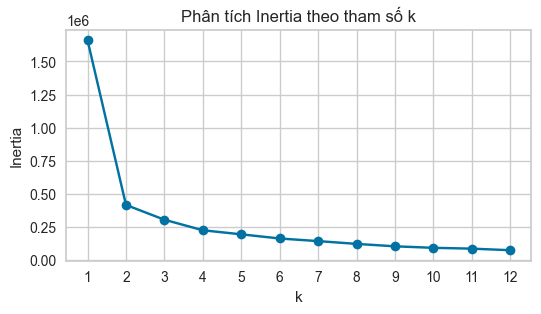

In [105]:
##  Biểu diễn trực quan Inertia --> xác định elbow
#Đánh gia bằng elbow -> chỉ KmeansKmeans
plt.figure(figsize = (6, 3))
plt.plot(nbClusters, scores, 'bo-')
plt.xlabel('k')
plt.xticks(nbClusters)
plt.ylabel('Inertia')
plt.title('Phân tích Inertia theo tham số k')

plt.show()
#Chọn k = 2

chỉ dùng được với kmeans

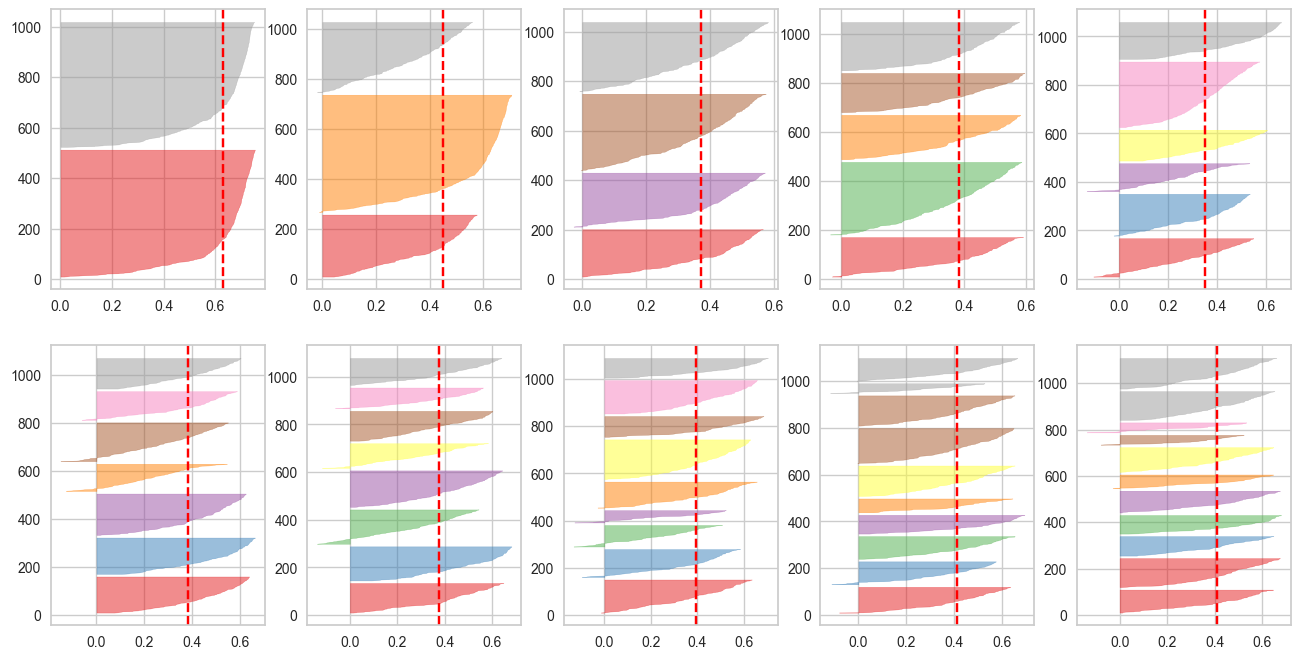

In [106]:
## Biểu diễn trực quan Silhouette plot bằng thư viện YellowBrick
## https://dzone.com/articles/kmeans-silhouette-score-explained-with-python-exam
from yellowbrick.cluster import SilhouetteVisualizer

nbClusters = range(2, 12)
fig, ax = plt.subplots(2, 5, figsize = (16, 8)) # 2 rows, 5 cols

for k in nbClusters:
    model = KMeans(n_clusters = k)
    row, col = divmod(k - 2, 5) # tọa độ subplot

    visualizer = SilhouetteVisualizer(model, ax = ax[row][col])
    visualizer.fit(df)
## Vạch đứng đứt nét thể hiện Silouette trung bình
## Mỗi data point xi sẽ có score là vạch nằm ngang
## Những clusters có shape nhọn phía bên phải là không tốt

In [107]:
k = 2
model_KMeans = KMeans(n_clusters = k)
model_KMeans.fit(df)

KMeans(n_clusters=2)

***AgglomerativeClustering***

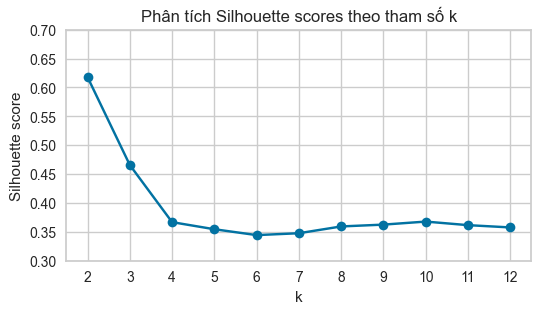

Giá trị tối ưu cho tham số: k = 2


In [108]:
#Đánh giá các k bằng silhouette
## Phân tích Silhouette scores theo giá trị của tham số k
nbClusters  = range(2, 13) # Lưu ý: (k >= 2) vì cần tính khoảng cách từ xi đến nearest cluster
silhouettes = []
for k in nbClusters:
    model = AgglomerativeClustering(n_clusters = k, metric = 'euclidean', linkage = 'ward')
    model.fit(df)
    silhouettes.append(silhouette_score(df, model.fit_predict(df), metric = 'euclidean'))

plt.figure(figsize = (6, 3))
plt.plot(nbClusters, silhouettes, 'bo-')
plt.xlabel('k')
plt.xticks(nbClusters)
plt.ylabel('Silhouette score')
plt.yticks(np.arange(0.3, 0.75, 0.05))
plt.title('Phân tích Silhouette scores theo tham số k')

plt.show()
print(f'Giá trị tối ưu cho tham số: k = {nbClusters[np.argmax(silhouettes)]}')

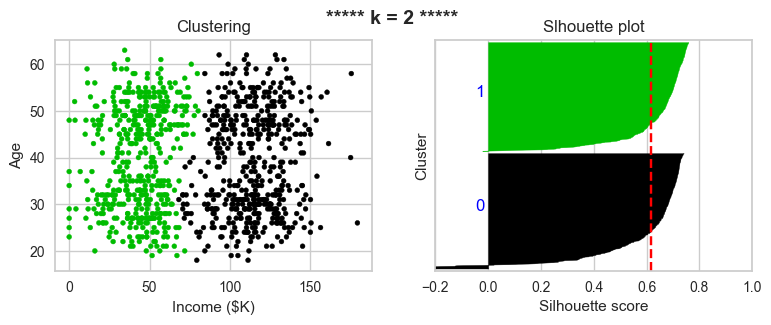

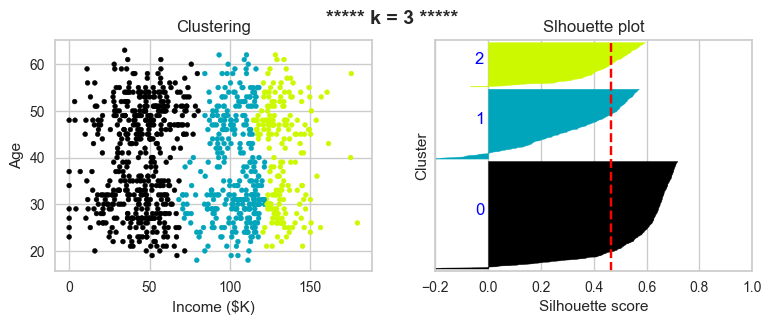

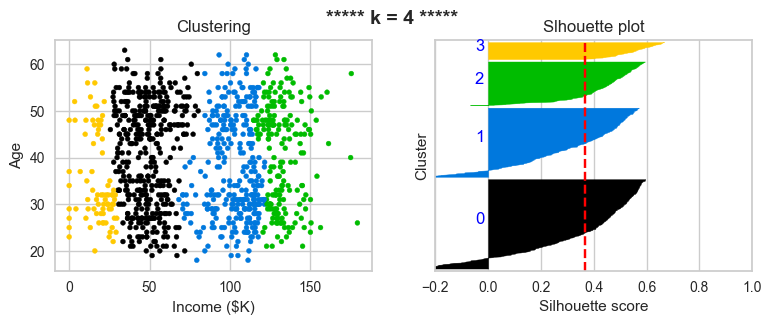

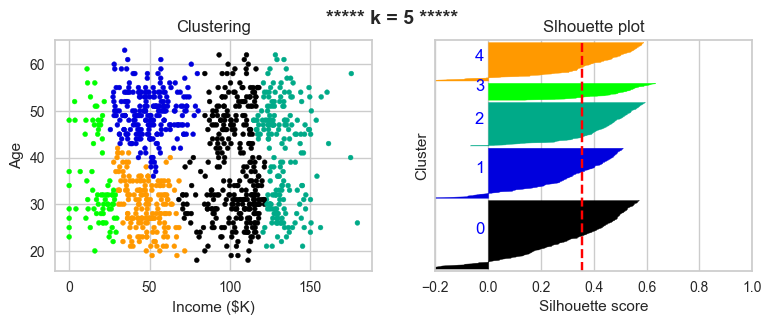

In [110]:
## Biểu diễn trực quan clustering và phân tích silhouette scores theo tham số k
## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
nbClusters = range(2, 6)
xmin       = min(silhouettes) # kết quả nhận được từ phía trên

for k in nbClusters:
    # Thực hiện kMeans với tham số k
    model  = AgglomerativeClustering(n_clusters = k, metric = 'euclidean', linkage = 'ward')
    model.fit(df)
    labels = model.fit_predict(df) # nhãn của clusters

    # Biểu diễn trực quan
    fig, (ax1, ax2) = plt.subplots(1, 2) # ax1: scatter plot; ax2: Silhouette plot
    fig.set_size_inches(9, 3)

    ax1.set_title('Clustering')
    ax1.set_xlabel('Income ($K)')
    ax1.set_ylabel('Age')
    colors = plt.cm.nipy_spectral(labels.astype(float) / k) # phổ mầu cho clusters
    ax1.scatter(df.income, df.age, marker = '.', c = colors)

    # # Các trọng tâm
    # centroids = model.cluster_centers_
    # ax1.scatter(centroids[:, 0], centroids[:, 1],
    #             marker = 'o', c = 'cyan', alpha = 1, s = 200, edgecolor = 'k')
    # for i, center in enumerate(centroids):
    #     ax1.scatter(center[0], center[1],
    #                 marker = '$%d$' % i, alpha = 1, s = 50, edgecolor = 'k')

    # Silhouette trung bình cho tất cả samples
    silhouette_avg = silhouette_score(df, labels)

    # Silhouette scores cho mỗi sample (data point) xi
    silhouettes_samples = silhouette_samples(df, labels)

    # Silhouette plot
    ax2.set_xlim([xmin, 1])
    ax2.set_ylim([0, len(df) + (k + 1) * 10])
    ax2.set_title('Slhouette plot')
    ax2.set_xlabel('Silhouette score')
    ax2.set_ylabel('Cluster')

    # Vạch đứng đứt nét thể hiện Silouette trung bình
    ax2.axvline(x = silhouette_avg, color = 'red', linestyle = '--')

    ax2.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax2.set_yticks([])  # Xóa ticks trên trục tung

    # Vẽ silhouette scores cho từng cluster Ci
    y_lower = 10 # tung độ bắt đầu vẽ
    for Ci in range(k):
        # Silhouette scores của các samples trong cluster Ci (sắp xếp giảm dần)
        silhouette_Ci = silhouettes_samples[labels == Ci]
        silhouette_Ci.sort()

        size_Ci = silhouette_Ci.shape[0]
        y_upper = y_lower + size_Ci # tung độ kết thúc của Ci

        # Vẽ các đường ngang thể hiện silhouette scores của Ci
        color = cm.nipy_spectral(float(Ci) / k) # phổ mầu
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, silhouette_Ci,
                          facecolor = color, edgecolor = color)

        # Hiện label của cluster Ci ở phía bên trái
        ax2.text(-0.05, y_lower + 0.5 * size_Ci, str(Ci), color = 'blue')
        plt.suptitle(f'***** k = {k} *****', fontsize = 14, fontweight = 'bold')

        # Tung độ cho cluster kế tiếp
        y_lower = y_upper + 10  # 10 là độ cách

plt.show()

In [111]:
#K = 2 là tốt nhất
k =2
model_HAC = AgglomerativeClustering(n_clusters = k, linkage = 'ward', metric = 'euclidean')
model_HAC.fit(df)

AgglomerativeClustering()

***DBSCAN***

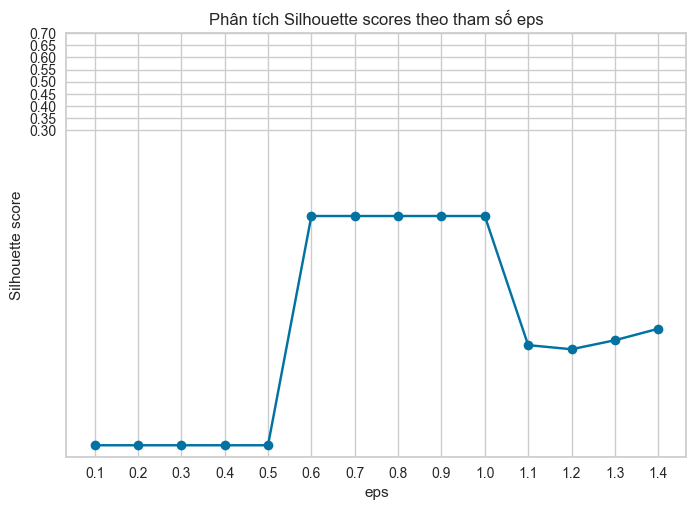

Giá trị tối ưu cho tham số: k = 0.6


In [112]:
#Đánh giá các k bằng silhouette
## Phân tích Silhouette scores theo giá trị của tham số k
epsValues = np.arange(0.1, 1.5, 0.1)
silhouettes = []
for eps in epsValues:
    model = DBSCAN(eps = eps, min_samples = 5)
    model.fit(df)
    # silhouettes.append(silhouette_score(df, model.labels_, metric = 'euclidean'))
    labels = model.labels_
    if len(set(labels)) > 1:
        silhouettes.append(silhouette_score(df, labels, metric='euclidean'))
    else:
        silhouettes.append(-1)

# plt.figure(figsize = (6, 3))
plt.plot(epsValues, silhouettes, 'bo-')
plt.xlabel('eps')
plt.xticks(epsValues)
plt.ylabel('Silhouette score')
plt.yticks(np.arange(0.3, 0.75, 0.05))
plt.title('Phân tích Silhouette scores theo tham số eps')

plt.show()
print(f'Giá trị tối ưu cho tham số: k = {epsValues[np.argmax(silhouettes)]}')

In [113]:
model_DBSCAN = DBSCAN(eps = 0.6, min_samples = 5)
model_DBSCAN.fit(df)

DBSCAN(eps=0.6)

***SO SANH MODEL***

In [114]:
models = {
    'KMeans': model_KMeans,
    'HAC'   : model_HAC,
    'DBSCAN': model_DBSCAN
}

list_modelLabels = {}
silhouettes = []

for name, model in models.items():
    labels = model.fit_predict(df)
    silhouettes.append(silhouette_score(df, labels))
    list_modelLabels[name] = labels
    print(f'{name}: {silhouettes[-1]}')

print(f'Model tốt nhất: {list(models.keys())[np.argmax(silhouettes)]}')

KMeans: 0.6287360194539515
HAC: 0.6179182076037241
DBSCAN: -0.05414705980320647
Model tốt nhất: KMeans


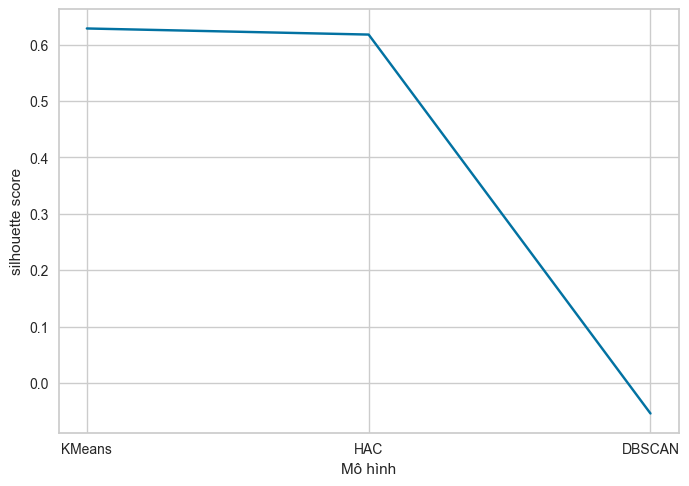

In [115]:
## Biểu diễn trực quan
plt.plot(list_modelLabels.keys(), silhouettes)
plt.xlabel('Mô hình')
plt.ylabel('silhouette score')
plt.show()

In [116]:
model = models['KMeans']
df['Cluster'] = list_modelLabels['KMeans']
df

,income,age,Cluster
0,101.743,58,0
1,49.597,27,1
2,36.517,52,1
3,33.223,49,1
4,72.994,53,1
...,...,...,...
995,70.615,29,1
996,95.102,41,0
997,42.203,35,1
998,16.975,31,1


Text(0.5, 1.0, 'Clusters of customers')

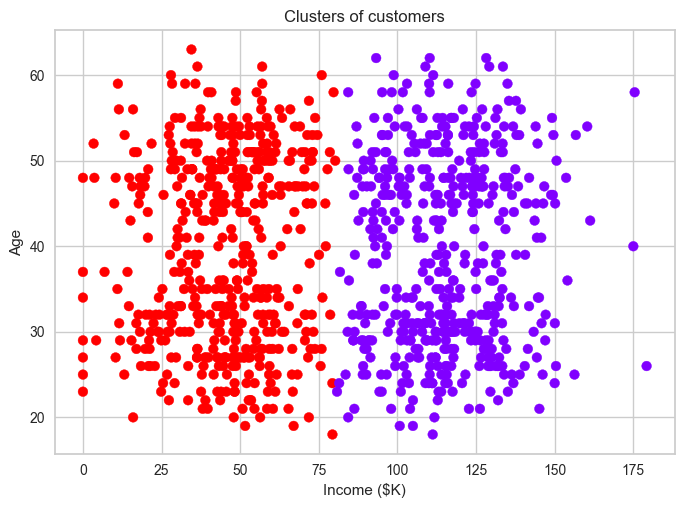

In [117]:
plt.scatter(df['income'], df['age'], c = df['Cluster'], cmap = 'rainbow')
plt.xlabel('Income ($K)')
plt.ylabel('Age')
plt.title('Clusters of customers')